# Tabla de resultados
1. Lectura y todos los subresultados

In [1]:
## Get current work directory to load all the custom modules
from pathlib import Path
import sys
BASE_DIR = Path().absolute().resolve(strict=True).parent
if str(BASE_DIR) not in sys.path:
    sys.path.append(str(BASE_DIR))

In [2]:
DATA_PATH = os.path.join(BASE_DIR, 'data', 'autos')
print(DATA_PATH)

/workspace/Externos/TimeSeries/BenchMark/data/autos


In [3]:
import datetime as dt
import pandas as pd
import numpy as np
import glob

># 1. Lectura y Formateo de datos

In [4]:
csv_paths1 = glob.glob(os.path.join(DATA_PATH + "/result/**/", '*.csv'))
csv_paths2 = glob.glob(os.path.join(DATA_PATH + "/result/**/**/", '*.csv'))
csv_paths = csv_paths1 + csv_paths2

### MSE - tabla de resultados

In [5]:
# Hyperparameters by model
for i, csv_result in enumerate(csv_paths):
    result = pd.read_csv(csv_result, usecols=['idArticulo', 'hyper', 'model'])
    model_name = result.model.sample().tolist()[0]
    result.drop(['model'], axis=1, inplace=True)
    result.columns = ['idArticulo', model_name]
    if i == 0:
        data_hyper = result
    else:
        data_hyper = pd.merge(data_hyper, result, on='idArticulo', how='outer')
data_hyper = data_hyper.fillna(1e2)
data_hyper = data_hyper.set_index('idArticulo')
data_hyper.head()

,ARIMA,DL,LR,DT,XGB
idArticulo,,,,,
551.0,"{'ar': 2, 'ii': 1, 'ma': 2}","{'n_lags': 6, 'random_state': 2073, 'optimizer...",{'n_lags': 6},"{'n_lags': 2, 'max_depth': 7, 'random_state': ...","{'n_lags': 2, 'max_depth': 6, 'random_state': ..."
594.0,"{'ar': 2, 'ii': 3, 'ma': 5}","{'n_lags': 6, 'random_state': 1474, 'optimizer...",{'n_lags': 5},"{'n_lags': 7, 'max_depth': 3, 'random_state': ...","{'n_lags': 3, 'max_depth': 4, 'random_state': ..."
963.0,"{'ar': 4, 'ii': 1, 'ma': 0}","{'n_lags': 4, 'random_state': 1944, 'optimizer...",{'n_lags': 2},"{'n_lags': 4, 'max_depth': 7, 'random_state': ...","{'n_lags': 4, 'max_depth': 3, 'random_state': ..."
1208.0,"{'ar': 2, 'ii': 1, 'ma': 0}","{'n_lags': 7, 'random_state': 2340, 'optimizer...",{'n_lags': 11},"{'n_lags': 5, 'max_depth': 5, 'random_state': ...","{'n_lags': 6, 'max_depth': 3, 'random_state': ..."
1224.0,"{'ar': 4, 'ii': 2, 'ma': 6}","{'n_lags': 6, 'random_state': 1083, 'optimizer...",{'n_lags': 2},"{'n_lags': 5, 'max_depth': 5, 'random_state': ...","{'n_lags': 3, 'max_depth': 5, 'random_state': ..."


In [6]:
# MSE by model
for i, csv_result in enumerate(csv_paths):
    result = pd.read_csv(csv_result, usecols=['idArticulo', 'mse_test', 'model'])
    model_name = result.model.sample().tolist()[0]
    result.drop(['model'], axis=1, inplace=True)
    result.columns = ['idArticulo', model_name]
    if i == 0:
        data = result
    else:
        data = pd.merge(data, result, on='idArticulo', how='outer')
data = data.fillna(1e2)
data = data.set_index('idArticulo')
data = np.sqrt(data)
data.head()

,ARIMA,DL,LR,DT,XGB
idArticulo,,,,,
551.0,0.636347,0.649069,0.600816,0.708790,0.309757
594.0,1.959835,1.810802,1.948572,0.935993,1.414064
963.0,1.413145,1.013708,1.259671,1.538184,1.152374
1208.0,0.298649,0.180316,0.489757,0.404063,0.338838
1224.0,1.314405,1.164804,1.138342,1.486953,0.820563


In [7]:

columns = data.columns.tolist()
min_mse = data.min(axis=1).tolist()

def set_model(x, columns, hyper):
    index = x.tolist().index(x.min())
    hyper = hyper.loc[x.name, columns[index]]
    return pd.Series(index=['model', 'rmse', 'hyper'], data=[columns[index],x.min(), hyper])
print("="*20 + " RESUMEN RMSE " + "="*20)
hyper_model = data.apply(set_model, args=(columns, data_hyper ), axis=1)
data = data.join(hyper_model)
data
data.style.background_gradient(cmap='Blues')


==================== RESUMEN RMSE ====================


,ARIMA,DL,LR,DT,XGB,model,rmse,hyper
idArticulo,,,,,,,,
551.0,0.636347,0.649069,0.600816,0.708790,0.309757,XGB,0.309757,"{'n_lags': 2, 'max_depth': 6, 'random_state': 410, 'gamma': 0.1989850279800391, 'n_estimators': 10}"
594.0,1.959835,1.810802,1.948572,0.935993,1.414064,DT,0.935993,"{'n_lags': 7, 'max_depth': 3, 'random_state': 973, 'ccp_alpha': 0.09567362522116188}"
963.0,1.413145,1.013708,1.259671,1.538184,1.152374,DL,1.013708,"{'n_lags': 4, 'random_state': 1944, 'optimizer': 'SGD', 'learning_rate': 0.0001, 'n_epochs': 150}"
1208.0,0.298649,0.180316,0.489757,0.404063,0.338838,DL,0.180316,"{'n_lags': 7, 'random_state': 2340, 'optimizer': 'SGD', 'learning_rate': 7.000000000000001e-05, 'n_epochs': 150}"
1224.0,1.314405,1.164804,1.138342,1.486953,0.820563,XGB,0.820563,"{'n_lags': 3, 'max_depth': 5, 'random_state': 2718, 'gamma': 0.6894119958309484, 'n_estimators': 9}"
1627.0,1.089330,1.607492,1.206481,2.391700,1.022931,XGB,1.022931,"{'n_lags': 4, 'max_depth': 3, 'random_state': 1904, 'gamma': 0.13055965414451284, 'n_estimators': 2}"
3090.0,1.553446,1.251151,0.870240,1.795286,1.374776,LR,0.870240,{'n_lags': 2}
3882.0,0.194878,1.162303,0.408468,0.927375,0.743374,ARIMA,0.194878,"{'ar': 4, 'ii': 2, 'ma': 5}"
3883.0,1.238868,1.458789,1.086598,1.351812,0.979980,XGB,0.979980,"{'n_lags': 5, 'max_depth': 5, 'random_state': 1230, 'gamma': 0.0056306132846087875, 'n_estimators': 2}"


## Autocorrelación por gráfica ACF CI 95% white noise

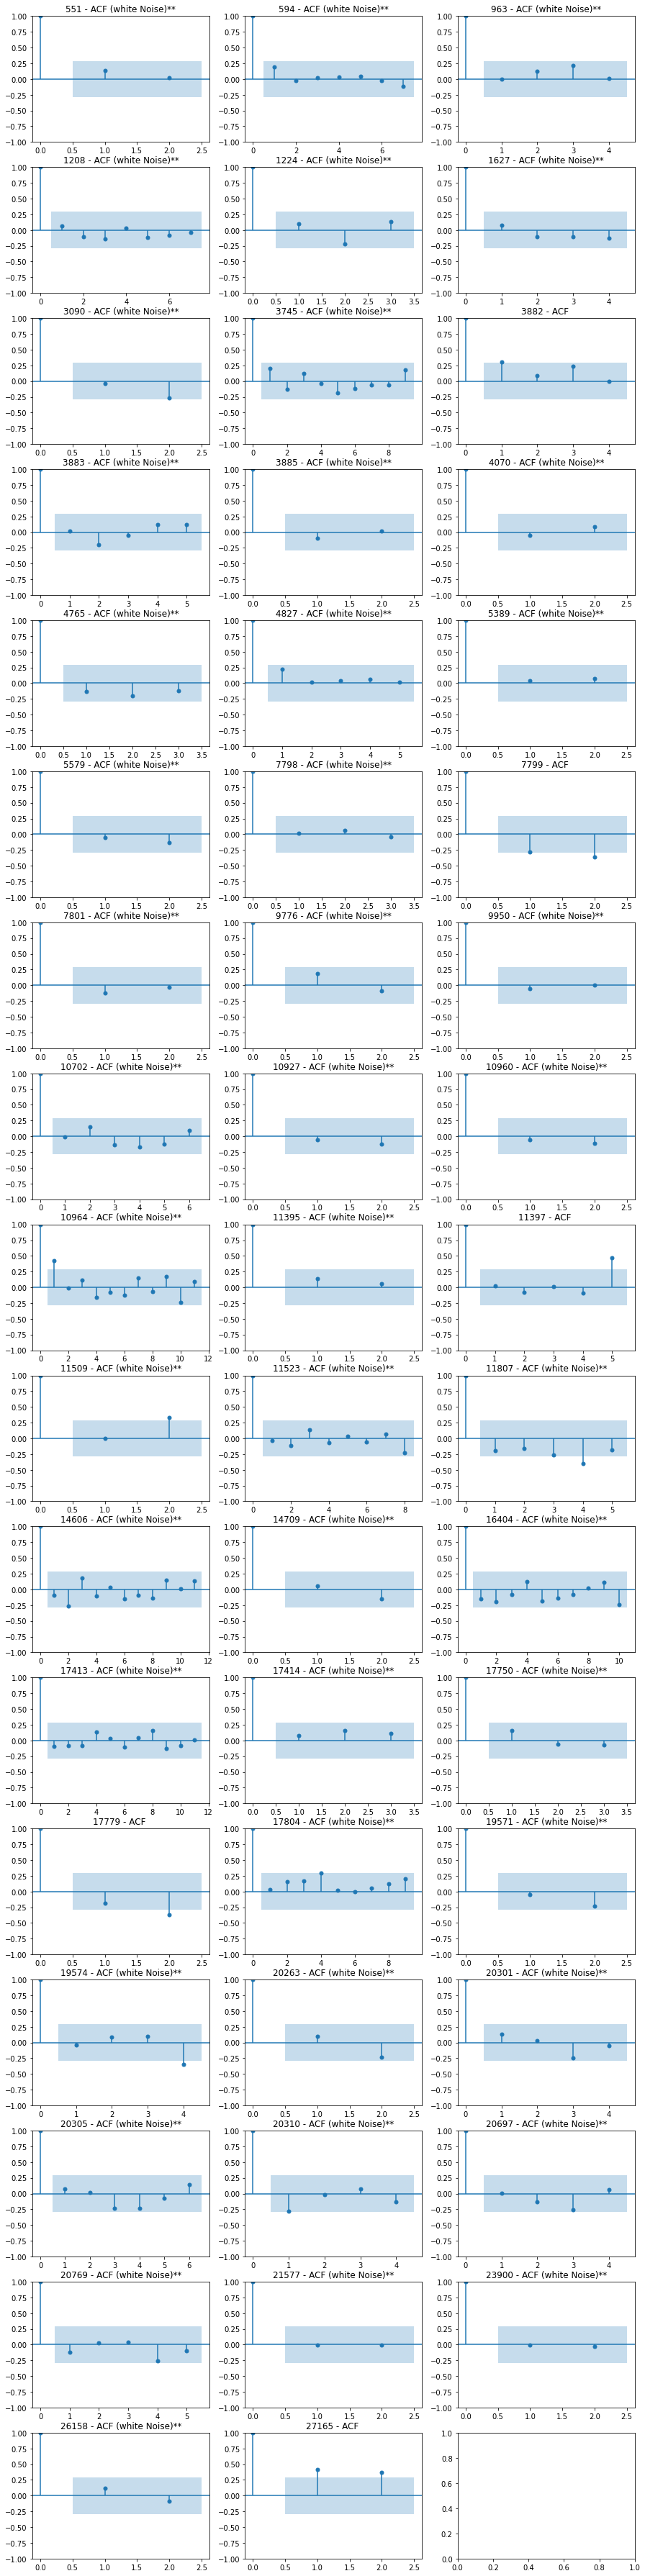

In [8]:
from modulos.arima.gruas.general import format_timeseries
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_pacf
from modulos.LR.gruas.generals import make_timeserie_arima
import statsmodels.api as sm
import json

data_ts = pd.read_csv(os.path.join(DATA_PATH, 'producto.csv'), parse_dates=['Periodo'])
df_time = format_timeseries(data_ts)
data["trustworthy"] = None
articulos = df_time.columns.tolist()
fig, axs = plt.subplots(round(len(articulos)/3), 3, figsize=(15, 65))
axs = axs.flatten()
for idx, articulo in enumerate(articulos):
    ts, _ = make_timeserie_arima(df_time[articulo].copy())
    nlags = json.loads(data.loc[articulo,"hyper"].replace("'","\""))
    
    n_lags = nlags.get('n_lags',None)
    if n_lags is None:
        n_lags = nlags.get('ar',None)
    val = sm.stats.acorr_ljungbox(ts, lags=[n_lags],)
    wn = val['lb_pvalue'].tolist()[0] < 0.05 # if True then this is not a white noise serie
    tag = "(white Noise)**" if not wn else ""
    data.loc[articulo, "trustworthy"] = wn
    plot_pacf(ts, lags=n_lags, method='ywm', title=str(articulo) + " - ACF " + tag, ax=axs[idx])
    

In [9]:

data

,ARIMA,DL,LR,DT,XGB,model,rmse,hyper,trustworthy
idArticulo,,,,,,,,,
551.0,0.636347,0.649069,0.600816,0.708790,0.309757,XGB,0.309757,"{'n_lags': 2, 'max_depth': 6, 'random_state': ...",False
594.0,1.959835,1.810802,1.948572,0.935993,1.414064,DT,0.935993,"{'n_lags': 7, 'max_depth': 3, 'random_state': ...",False
963.0,1.413145,1.013708,1.259671,1.538184,1.152374,DL,1.013708,"{'n_lags': 4, 'random_state': 1944, 'optimizer...",False
1208.0,0.298649,0.180316,0.489757,0.404063,0.338838,DL,0.180316,"{'n_lags': 7, 'random_state': 2340, 'optimizer...",False
1224.0,1.314405,1.164804,1.138342,1.486953,0.820563,XGB,0.820563,"{'n_lags': 3, 'max_depth': 5, 'random_state': ...",False
1627.0,1.089330,1.607492,1.206481,2.391700,1.022931,XGB,1.022931,"{'n_lags': 4, 'max_depth': 3, 'random_state': ...",False
3090.0,1.553446,1.251151,0.870240,1.795286,1.374776,LR,0.870240,{'n_lags': 2},False
3882.0,0.194878,1.162303,0.408468,0.927375,0.743374,ARIMA,0.194878,"{'ar': 4, 'ii': 2, 'ma': 5}",True
3883.0,1.238868,1.458789,1.086598,1.351812,0.979980,XGB,0.979980,"{'n_lags': 5, 'max_depth': 5, 'random_state': ...",False


In [10]:
data.to_csv(os.path.join(DATA_PATH, 'resumen_rmse.csv'))